#### Data Download
https://www.kaggle.com/datasets/htagholdings/property-sales 
I think you'll want to use the ma_lga_12345.csv file, but feel free to use the raw_sales.csv file instead if you wish.

### Assignment Specs

- Implement at least one recurrent neural network model (e.g. SimpleRNN, LSTM, etc.) with these data to predict Sales.
Remember that train-testing works a little differently for time series data (i.e. it should NOT be random)
- A secondary goal of this assignment is to explore this very different, temporal prediction task.
    - Experiment with at least 3 different train-test splits
    - Experiment with at least 3 different values for the amount of history to include in the model (e.g. one time step, two, three, etc.). The data preprocessing for this may vary by the type of RNN used.
    - Plot your results! Raw data with predictions...
- Your submission should be built and written with non-experts as the target audience. All of your code should still be included, but do your best to narrate your work in accessible ways.

### Apuntes
#### RNN
- A recurrent neural network (RNN) is a special type of neural network adapted to work for time series data or data that involves sequences 
- Ordinary neural networks are only meant for data points
which are independent of each other - RNNs have the concept of “memory”

- Pros:
1. Ability to handle sequence data
2. Ability to handle inputs of varying lengths
3. Ability to store or “memorize” historical information

- Cons:
1. The computation can be very slow
2. The network does not take into account future inputs to make decisions
3. Vanishing gradient problem, where the gradients used to compute the weight update may get very close to zero
preventing the network from learning new weights (the deeper the network, the more pronounced is this problem) 
    - It is difficult to capture long term dependencies because of a multiplicative gradient that can be exponentially decreasing/increasing with respect to the number of layers

- Types of RNN Architectures:

    - Bidirectional recurrent neural networks (BRNN): Inputs from future time steps are used to improve the accuracy
of the network (e.g. like having knowledge of the first and last words of a sentence to predict the middle words)

    - Gated Recurrent Units (GRU): Designed to handle the vanishing gradient problem. They have a reset and update gate, which determine which information is to be retained for future predictions

    - Long Short-Term Memory (LSTM): Also designed to address the vanishing gradient problem. Use three gates called input, output, and forget gate...similar to GRU

#### LSTM and GRU
- RNNs suffer from short-term memory:
    - If a sequence is long enough, they’ll have a heard time carrying information from earlier time steps to later ones
    - Vanishing gradient problem: values used to update weights can become very small as they propagate back through time, leading to smaller/less learning

**SOLUTION**: LSTM and GRU

- Hidden units act as the neural network’s memory:
1. The input and previous hidden unit’s output are combined, and
fed to the current hidden unit (time step)
2. The activation function at this hidden unit is applied
3. ...this happens many times!

LSTM: 
The differences are in the hidden unit operations: Extra operations allow the LSTM to keep or forget information: forget gate, input gate, cell state, and output gate

GRU Differences:
- Slightly newer generation of RNN
- Removed cell state
- Only uses 2 gates: reset gate and update gate
- Update gate is similar to forget-and-input of the LSTM
- Reset gate also used to decide how much past information to forget
- Fewer operations means faster to train

### Import Data

In [1]:
import pandas as pd
import os
import kagglehub

# Download latest version
path = kagglehub.dataset_download("htagholdings/property-sales")

# Full file path
file_path = os.path.join(path, "raw_sales.csv")

# Load into DataFrame
df = pd.read_csv(file_path)

# make sure in datetime type 
df['date'] = pd.to_datetime(df['datesold'])

# drop any NaNs
df = df.dropna()

# Sort chronologically
df = df.sort_values('date') 

df.head()

,datesold,postcode,price,propertyType,bedrooms,date
0,2007-02-07 00:00:00,2607,525000,house,4,2007-02-07
1,2007-02-27 00:00:00,2906,290000,house,3,2007-02-27
2,2007-03-07 00:00:00,2905,328000,house,3,2007-03-07
3,2007-03-09 00:00:00,2905,380000,house,4,2007-03-09
4,2007-03-21 00:00:00,2906,310000,house,3,2007-03-21


### Model Experiment

Here is a function that achieves many functions. This model will go through all of the variations of rnn models using history steps 1, 3, and 5 and train_ratios of 0.7, 0.8, and 0.9. Then the Function will choose the bset resulting model based on MAE and plot its actual vs predicted values. 

In [30]:
def find_best_rnn_model(data_series, history_steps_list=[1, 3, 5], train_ratios=[0.7, 0.8, 0.9]):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Input, SimpleRNN, Dense
    from tensorflow.keras.callbacks import EarlyStopping
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
    import numpy as np
    import matplotlib.pyplot as plt

    def create_sequences(data, history=3):
        X, y = [], []
        for i in range(len(data) - history):
            X.append(data[i:i+history])
            y.append(data[i+history])
        return np.array(X), np.array(y)

    # Neural networks perform better with scaled data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data_series.values.reshape(-1, 1))

    results = []

    for history in history_steps_list:
        X, y = create_sequences(scaled_data, history)
        X = X.reshape((X.shape[0], X.shape[1], 1))

        for train_ratio in train_ratios:
            split = int(len(X) * train_ratio)
            X_train, X_test = X[:split], X[split:]
            y_train, y_test = y[:split], y[split:]

            model = Sequential([
                Input(shape=(history, 1)),
                SimpleRNN(32, activation='relu'),
                Dense(1)
            ])
            model.compile(optimizer='adam', loss='mse')
            es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
            model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=0, callbacks=[es])

            preds = model.predict(X_test)
            preds_inv = scaler.inverse_transform(preds)
            y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

            mae = mean_absolute_error(y_test_inv, preds_inv)
            rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
            mape = mean_absolute_percentage_error(y_test_inv, preds_inv)
            r2 = r2_score(y_test_inv, preds_inv)

            # Print each model's results here
            print(f"History: {history}, Train: {int(train_ratio*100)}%")
            print(f"  MAE:  {mae:.2f}")
            print(f"  RMSE: {rmse:.2f}")
            print(f"  MAPE: {mape * 100:.2f}%")
            print(f"  R²:   {r2:.4f}")

            results.append({
                'history': history,
                'train_ratio': train_ratio,
                'mae': mae,
                'rmse': rmse,
                'mape': mape,
                'r2': r2,
                'preds_inv': preds_inv,
                'y_test_inv': y_test_inv
            })

    # Find best model by MAE
    best = min(results, key=lambda x: x['mae'])

    # Print best
    print(f"\n📊 Best Model Found:")
    print(f"  History: {best['history']}, Train: {int(best['train_ratio']*100)}%")
    print(f"  MAE:  {best['mae']:.2f}")
    print(f"  RMSE: {best['rmse']:.2f}")
    print(f"  MAPE: {best['mape']*100:.2f}%")
    print(f"  R²:   {best['r2']:.4f}")

    # Plot
    n = min(300, len(best['y_test_inv']))
    plt.figure(figsize=(10, 4))
    plt.plot(best['y_test_inv'][-n:], label='Actual', color='red')
    plt.plot(best['preds_inv'][-n:], label='Predicted', color='blue')
    plt.title(f"Best Model • History={best['history']} • Train={int(best['train_ratio']*100)}%")
    plt.xlabel("Time Step")
    plt.ylabel("Sales")
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.show()

    return best


278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
History: 1, Train: 70%
  MAE:  184009.32
  RMSE: 295609.15
  MAPE: 29.43%
  R²:   0.0789
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
History: 1, Train: 80%
  MAE:  181954.66
  RMSE: 286549.49
  MAPE: 31.90%
  R²:   0.1213
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
History: 1, Train: 90%
  MAE:  173987.41
  RMSE: 265624.88
  MAPE: 30.32%
  R²:   0.0664
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
History: 3, Train: 70%
  MAE:  177725.77
  RMSE: 284403.74
  MAPE: 29.79%
  R²:   0.1474
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
History: 3, Train: 80%
  MAE:  180411.12
  RMSE: 285462.94
  MAPE: 31.17%
  R²:   0.1280
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
History: 3, Train: 90%
  MAE:  174393.42
  RMSE: 263343.72
  MAPE: 31.66%
  R²:   0.0824
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
History: 5, Train: 70%
  MAE:  178402.17
  RMSE: 284942.47
  MAPE: 29.85%
  R²:   0.1442
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
History: 5, Train: 80%
  MAE:  176711.48
  RMSE: 2861

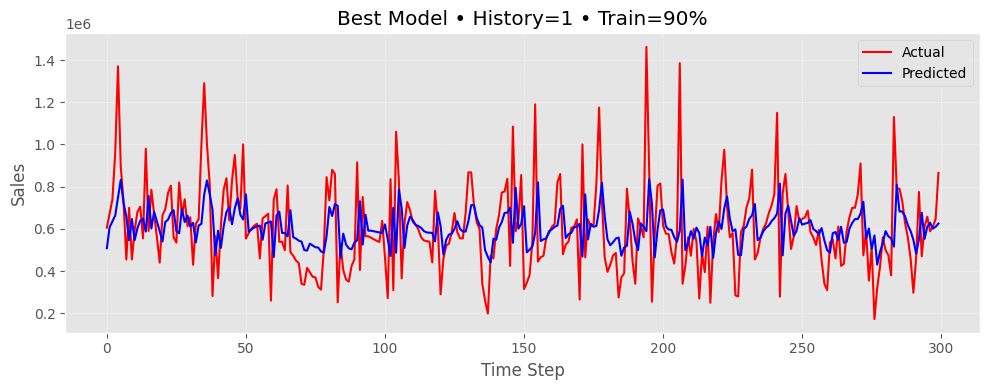

In [32]:
best_model = find_best_rnn_model(df['price'])

The best model identified, using a history window of 1 and a 90% training split, demonstrates a modest improvement but still reflects limited predictive performance. With a Mean Absolute Error (MAE) of approximately $173,987 and a Root Mean Squared Error (RMSE) of around $265,625, the model maintains a moderate level of deviation from actual sales values—potentially acceptable if the underlying sales figures are in the millions. However, the Mean Absolute Percentage Error (MAPE) sits at 30.32%, indicating that predictions are, on average, about 30% off—a figure that exceeds typical thresholds for accuracy in many applied business contexts. The R² score of 0.0664 suggests that the model explains only about 6.6% of the variance in the data, indicating that much of the underlying pattern remains uncaptured. While this configuration slightly outperforms others in the experiment, it still underscores the need for more sophisticated modeling approaches or feature enhancements to achieve more robust and actionable forecasts.